In [ ]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 62.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dense, Dropout
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import text_to_word_sequence

In [ ]:
df

,Class Index,Title,Description,text,clean_text
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Wall St. Bears Claw Back Into the Black (Reute...,wall st bears claw back into the black reuters...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Carlyle Looks Toward Commercial Aerospace (Reu...,carlyle looks toward commercial aerospace reut...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Oil and Economy Cloud Stocks' Outlook (Reuters...,oil and economy cloud stocks outlook reuters r...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Iraq Halts Oil Exports from Main Southern Pipe...,iraq halts oil exports from main southern pipe...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","Oil prices soar to all-time record, posing new...",oil prices soar to alltime record posing new m...
...,...,...,...,...,...
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...,Pakistan's Musharraf Says Won't Quit as Army C...,pakistans musharraf says wont quit as army chi...
119996,2,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...,Renteria signing a top-shelf deal Red Sox gene...,renteria signing a topshelf deal red sox gener...
119997,2,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...,Saban not going to Dolphins yet The Miami Dolp...,saban not going to dolphins yet the miami dolp...
119998,2,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...,Today's NFL games PITTSBURGH at NY GIANTS Time...,todays nfl games pittsburgh at ny giants time ...


In [ ]:
# Load dataset safely (AG News)
df = pd.read_csv("/content/train.csv", quotechar='"', on_bad_lines='skip', engine='python')

# Combine Title + Description
df['text'] = df['Title'] + " " + df['Description']

# Basic cleaning
def clean_text(text):
    text = re.sub(r'http\S+', '', str(text))
    text = re.sub(r'[^a-zA-Z ]', '', text)
    return text.lower()

df['clean_text'] = df['text'].apply(clean_text)

# Fix Class Index (ensure numeric)
df['Class Index'] = (
    df['Class Index']
    .astype(str)
    .str.extract(r'(\d+)')[0]
    .fillna(0)
    .astype(int)
)

# Drop invalid rows
df = df[df['Class Index'] != 0].reset_index(drop=True)

print("Data Loaded:", df.shape)
df

Data Loaded: (120000, 5)


,Class Index,Title,Description,text,clean_text
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Wall St. Bears Claw Back Into the Black (Reute...,wall st bears claw back into the black reuters...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Carlyle Looks Toward Commercial Aerospace (Reu...,carlyle looks toward commercial aerospace reut...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Oil and Economy Cloud Stocks' Outlook (Reuters...,oil and economy cloud stocks outlook reuters r...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Iraq Halts Oil Exports from Main Southern Pipe...,iraq halts oil exports from main southern pipe...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","Oil prices soar to all-time record, posing new...",oil prices soar to alltime record posing new m...
...,...,...,...,...,...
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...,Pakistan's Musharraf Says Won't Quit as Army C...,pakistans musharraf says wont quit as army chi...
119996,2,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...,Renteria signing a top-shelf deal Red Sox gene...,renteria signing a topshelf deal red sox gener...
119997,2,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...,Saban not going to Dolphins yet The Miami Dolp...,saban not going to dolphins yet the miami dolp...
119998,2,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...,Today's NFL games PITTSBURGH at NY GIANTS Time...,todays nfl games pittsburgh at ny giants time ...


In [ ]:
df['Class Index'].value_counts()

,count
Class Index,
3,30000
4,30000
2,30000
1,30000


In [ ]:
X = df['clean_text'].values
y = df['Class Index'].values - 1
y = to_categorical(y)

In [ ]:
max_words = 10000   # smaller vocab = faster training
max_len = 80        # shorter sequences = faster CPU training

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X)

X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=max_len, padding='post')

X_train, X_test, y_train, y_test = train_test_split(
    X_pad, y, test_size=0.2, random_state=42, stratify=y
)

print("✅ Tokenization complete:", X_train.shape, X_test.shape)

✅ Tokenization complete: (96000, 80) (24000, 80)


In [ ]:
# Convert each text into a list of tokens
sentences = [text_to_word_sequence(t) for t in df['clean_text']]

# Train Word2Vec on your dataset
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4, sg=1)

print(f"✅ Word2Vec trained on {len(w2v_model.wv)} unique tokens")

✅ Word2Vec trained on 50218 unique tokens


In [ ]:
embedding_dim = 100
word_index = tokenizer.word_index

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        if word in w2v_model.wv:
            embedding_matrix[i] = w2v_model.wv[word]

print("Embedding matrix created:", embedding_matrix.shape)

Embedding matrix created: (10000, 100)


In [ ]:
model_w2v = Sequential([
    Embedding(input_dim=max_words,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_len,
              trainable=False),
    Bidirectional(GRU(64, dropout=0.2)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')
])

model_w2v.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_w2v.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,000 (3.81 MB)

In [ ]:
history_w2v = model_w2v.fit(
    X_train, y_train,
    epochs=5,
    batch_size=128,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 168s 219ms/step - accuracy: 0.7869 - loss: 0.5737 - val_accuracy: 0.9022 - val_loss: 0.2830
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 165s 219ms/step - accuracy: 0.8876 - loss: 0.3208 - val_accuracy: 0.9035 - val_loss: 0.2694
Epoch 3/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 166s 221ms/step - accuracy: 0.8951 - loss: 0.3000 - val_accuracy: 0.9094 - val_loss: 0.2573
Epoch 4/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 165s 220ms/step - accuracy: 0.9015 - loss: 0.2810 - val_accuracy: 0.9127 - val_loss: 0.2487
Epoch 5/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 165s 220ms/step - accuracy: 0.9062 - loss: 0.2681 - val_accuracy: 0.9138 - val_loss: 0.2457


In [ ]:
loss, acc = model_w2v.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy (Word2Vec): {acc*100:.2f}%")

Test Accuracy (Word2Vec): 91.38%


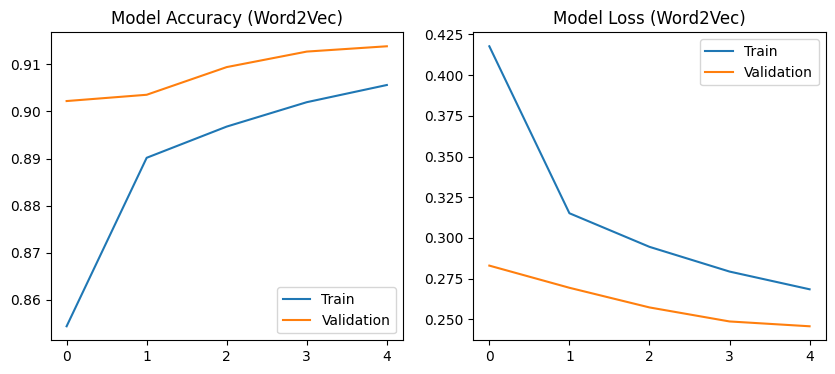

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_w2v.history['accuracy'], label='Train')
plt.plot(history_w2v.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy (Word2Vec)')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_w2v.history['loss'], label='Train')
plt.plot(history_w2v.history['val_loss'], label='Validation')
plt.title('Model Loss (Word2Vec)')
plt.legend()

plt.show()

In [ ]:
categories = ['World', 'Sports', 'Business', 'Sci/Tech']

def predict_category(text):
    text = clean_text(text)
    seq = tokenizer.texts_to_sequences([text])
    pad = pad_sequences(seq, maxlen=max_len, padding='post')
    pred = model_w2v.predict(pad)
    print("📰 Predicted Category:", categories[np.argmax(pred)])

# Example
predict_category("In ‘Jurassic Park’, John Hammond says, ‘Your scientists were so preoccupied with whether or not they could that they didn't stop to ask if they should.’ Thirty years later, this has never been as pertinent as it is today")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
📰 Predicted Category: Sci/Tech


In [ ]:
# Save trained GRU + Word2Vec model
model_w2v.save(r"news_category_gru_model.h5")
print("Model saved as news_category_gru_model.h5")

Model saved as news_category_gru_model.h5


In [ ]:
import pickle

# Save the tokenizer
with open("tokenizer.pkl", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Tokenizer saved as tokenizer.pkl")

Tokenizer saved as tokenizer.pkl


In [ ]:
w2v_model.save("custom_word2vec.model")
print("Word2Vec model saved as custom_word2vec.model")

Word2Vec model saved as custom_word2vec.model


In [ ]:
import os

for f in os.listdir():
    if f.endswith(('.h5', '.pkl', '.model')):
        print(f"📦 {f}")

📦 news_category_gru_model.h5
📦 tokenizer.pkl
📦 custom_word2vec.model


In [ ]:
from google.colab import files

files.download("news_category_gru_model.h5")
files.download("tokenizer.pkl")
files.download("custom_word2vec.model")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>